## Neural Network From Scratch

In [2]:

import numpy as np
import math
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

def set_seed(seed=42):
    global rng
    rng = np.random.default_rng(seed)

def make_toy_xor():
    # Four points in a classic XOR layout
    X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
    y = np.array([0,1,1,0], dtype=int)  # XOR labels
    return X, y

def plot_points_2d(X, y, title='Data', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    classes = np.unique(y)
    for c in classes:
        idx = (y == c)
        ax.scatter(X[idx,0], X[idx,1], label=f"class {c}")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    plt.show()

def one_hot(y, num_classes=None):
    if num_classes is None:
        num_classes = int(np.max(y)) + 1
    oh = np.zeros((y.shape[0], num_classes), dtype=float)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def train_val_split(X, y, val_ratio=0.25, seed=42):
    set_seed(seed)
    n = X.shape[0]
    idx = np.arange(n)
    rng.shuffle(idx)
    split = int(n*(1 - val_ratio))
    tr, va = idx[:split], idx[split:]
    return X[tr], y[tr], X[va], y[va]



## 2) The Neuron

A neuron computes a weighted sum plus bias, then applies an activation:
\[
y = f(w^\top x + b).
\]

We'll start with a **linear activation** (identity), then reuse the same shell for others.


In [3]:

class Neuron:
    def __init__(self, n_inputs):
        self.w = rng.standard_normal(n_inputs)
        self.b = rng.standard_normal()
    def forward(self, x, activation=lambda z: z):
        z = np.dot(self.w, x) + self.b
        return activation(z)

# Demo
x_demo = np.array([0.5, -1.2, 0.3])
neuron = Neuron(n_inputs=3)
print("Raw output (linear neuron):", neuron.forward(x_demo))
print("Sigmoid output:", neuron.forward(x_demo, activation=lambda z: 1/(1+np.exp(-z))))


Raw output (linear neuron): 2.5660395424989613
Sigmoid output: 0.9286437029873195



## 3) Linear Perceptron

The perceptron is a linear classifier with a step activation.  
It succeeds on **linearly separable** problems (e.g., AND), but fails on **XOR**.


In [5]:

def step(z): 
    return 1 if z >= 0 else 0

class Perceptron:
    def __init__(self, n_inputs, lr=0.1):
        self.w = np.zeros(n_inputs, dtype=float)
        self.b = 0.0
        self.lr = lr

    def predict(self, x):
        return step(np.dot(self.w, x) + self.b)

    def fit(self, X, y, epochs=20):
        for _ in range(epochs):
            for xi, yi in zip(X, y):
                pred = self.predict(xi)
                err = yi - pred
                self.w += self.lr * err * xi
                self.b += self.lr * err
        return self

# AND gate
X_and = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y_and = np.array([0,0,0,1], dtype=int)
perc = Perceptron(2, lr=0.2).fit(X_and, y_and)
print("Perceptron on AND:")
for x, y in zip(X_and, y_and):
    print(x, "-> pred:", perc.predict(x), "| true:", y)

# XOR (should fail)
X_xor, y_xor = make_toy_xor()
perc_xor = Perceptron(2, lr=0.2).fit(X_xor, y_xor)
print("\nPerceptron on XOR (expected to be wrong):")
for x, y in zip(X_xor, y_xor):
    print(x, "-> pred:", perc_xor.predict(x), "| true:", y)


Perceptron on AND:
[0. 0.] -> pred: 0 | true: 0
[0. 1.] -> pred: 0 | true: 0
[1. 0.] -> pred: 0 | true: 0
[1. 1.] -> pred: 1 | true: 1

Perceptron on XOR (expected to be wrong):
[0. 0.] -> pred: 1 | true: 0
[0. 1.] -> pred: 1 | true: 1
[1. 0.] -> pred: 0 | true: 1
[1. 1.] -> pred: 0 | true: 0



## 4) Activation Functions

We'll implement common nonlinearities and their derivatives:
- **Sigmoid**: smooth, but saturates
- **Tanh**: zero‑centered, still saturates
- **ReLU**: fast and simple, but has dead regions
- **Softmax**: converts scores to probabilities (output layer for multi‑class)


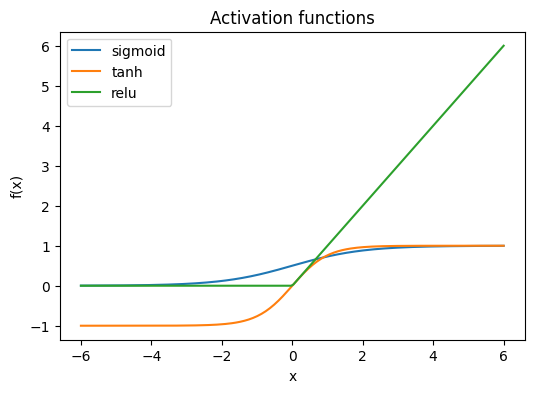

In [8]:

def sigmoid(z): 
    return 1.0/(1.0 + np.exp(-z))

def dsigmoid(z):
    s = sigmoid(z)
    return s*(1 - s)

def tanh(z): 
    return np.tanh(z)

def dtanh(z):
    t = np.tanh(z)
    return 1 - t**2

def relu(z): 
    return np.maximum(0.0, z)

def drelu(z): 
    return (z > 0).astype(float)

def softmax(z):
    # z shape: (C, N) or (C,1)
    z = z - np.max(z, axis=0, keepdims=True)
    ez = np.exp(z)
    return ez / np.sum(ez, axis=0, keepdims=True)

# Quick plots of activations (optional exploration)
xs = np.linspace(-6, 6, 200)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(xs, sigmoid(xs), label="sigmoid")
ax.plot(xs, tanh(xs), label="tanh")
ax.plot(xs, relu(xs), label="relu")
ax.set_title("Activation functions")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
plt.show()
# print(xs)


## 5) Feed‑Forward Neural Network (2‑Layer MLP) — Binary Classification (XOR)

We'll build a tiny MLP:  
**Input (2)** → **Hidden (H)** → **Output (1)** with sigmoid output (binary).  
We'll compare **sigmoid**, **tanh**, and **ReLU** hidden activations.


Hidden=sigmoid | acc=0.750 | final_loss=0.6451
Hidden=tanh    | acc=1.000 | final_loss=0.0080
Hidden=relu    | acc=0.750 | final_loss=0.3478


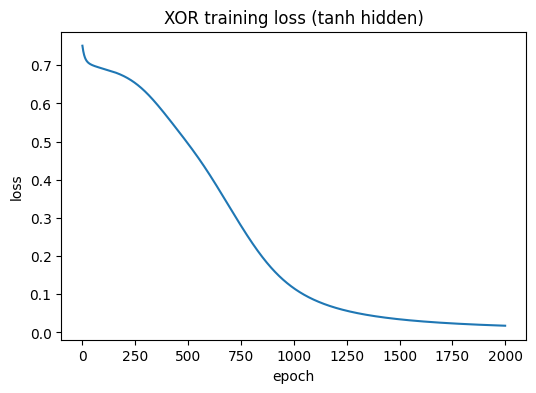

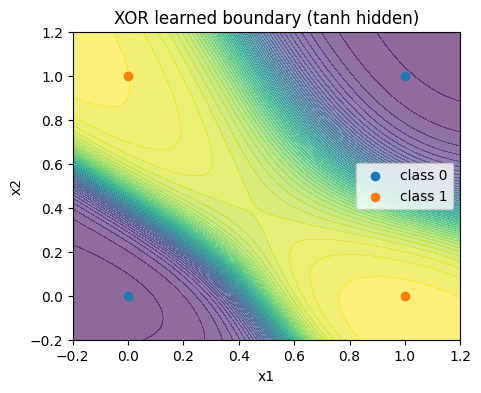

In [5]:

class MLPBinary:
    def __init__(self, input_dim=2, hidden_dim=4, lr=0.1, hidden_act='tanh'):
        self.W1 = rng.standard_normal((hidden_dim, input_dim))*0.5
        self.b1 = np.zeros((hidden_dim, 1))
        self.W2 = rng.standard_normal((1, hidden_dim))*0.5
        self.b2 = np.zeros((1,1))
        self.lr = lr
        acts = {
            'sigmoid': (sigmoid, dsigmoid),
            'tanh': (tanh, dtanh),
            'relu': (relu, drelu),
        }
        self.h_act, self.h_dact = acts[hidden_act]

    def forward(self, X):  # X: (N,2)
        Z1 = (self.W1 @ X.T) + self.b1  # (H,N)
        A1 = self.h_act(Z1)             # (H,N)
        Z2 = (self.W2 @ A1) + self.b2   # (1,N)
        A2 = sigmoid(Z2)                # (1,N) probability
        cache = (X, Z1, A1, Z2, A2)
        return A2, cache

    def compute_loss(self, y_true, y_prob):
        # y_true: (N,), y_prob: (1,N)
        eps = 1e-9
        y = y_true.reshape(1, -1)
        loss = -np.mean(y*np.log(y_prob+eps) + (1-y)*np.log(1 - y_prob + eps))
        return loss

    def backward(self, cache, y_true):
        X, Z1, A1, Z2, A2 = cache
        N = X.shape[0]
        y = y_true.reshape(1, -1)

        dZ2 = (A2 - y) / N                      # (1,N)
        dW2 = dZ2 @ A1.T                        # (1,H)
        db2 = np.sum(dZ2, axis=1, keepdims=True)  # (1,1)

        dA1 = self.W2.T @ dZ2                   # (H,N)
        dZ1 = dA1 * self.h_dact(Z1)             # (H,N)
        dW1 = dZ1 @ X                           # (H,2)
        db1 = np.sum(dZ1, axis=1, keepdims=True)   # (H,1)

        # Update
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, y, epochs=2000, verbose=False):
        losses = []
        for ep in range(epochs):
            y_hat, cache = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            losses.append(loss)
            self.backward(cache, y)
            if verbose and (ep+1) % (epochs//5) == 0:
                print(f"epoch {ep+1}/{epochs} loss={loss:.4f}")
        return losses

    def predict(self, X, thresh=0.5):
        y_prob, _ = self.forward(X)
        return (y_prob.flatten() >= thresh).astype(int)

# Train on XOR with different hidden activations
X, y = make_toy_xor()
for act in ['sigmoid','tanh','relu']:
    set_seed(42)
    model = MLPBinary(hidden_dim=4, lr=0.1, hidden_act=act)
    losses = model.fit(X, y, epochs=3000, verbose=False)
    y_pred = model.predict(X)
    acc = np.mean(y_pred == y)
    print(f"Hidden={act:7s} | acc={acc:.3f} | final_loss={losses[-1]:.4f}")

# Plot loss curve for one run
set_seed(42)
model = MLPBinary(hidden_dim=4, lr=0.1, hidden_act='tanh')
losses = model.fit(X, y, epochs=2000)
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("XOR training loss (tanh hidden)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Decision boundary visualization
def plot_decision_boundary_binary(model, X, y, title="Decision boundary"):
    x_min, x_max = X[:,0].min()-0.2, X[:,0].max()+0.2
    y_min, y_max = X[:,1].min()-0.2, X[:,1].max()+0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.forward(grid)[0].reshape(xx.shape)
    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, probs, levels=50, alpha=0.6)
    for c in np.unique(y):
        idx = (y==c)
        plt.scatter(X[idx,0], X[idx,1], label=f"class {c}")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
    plt.show()

plot_decision_boundary_binary(model, X, y, title="XOR learned boundary (tanh hidden)")



## 6) Softmax Output Layer — Multi‑Class Classification

We'll generate a simple 2D 3‑class dataset (three Gaussian blobs) and train an MLP:  
**Input (2)** → **Hidden (H)** → **Output (3, softmax)** with cross‑entropy loss.


Train accuracy (3-class, softmax): 1.000


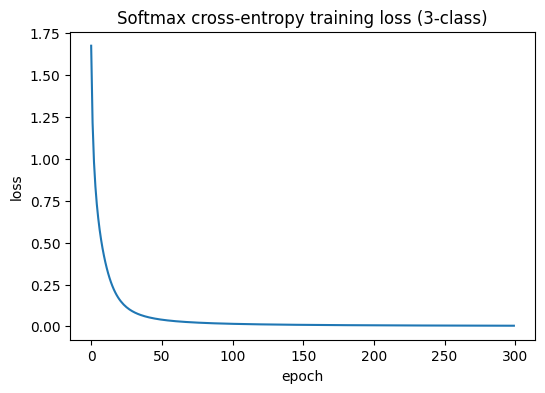

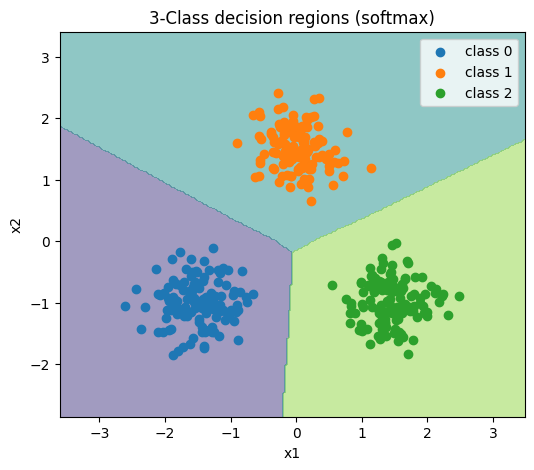

In [6]:

def make_3class_blobs(n_per_class=100, spread=0.4, seed=7):
    rng_local = np.random.default_rng(seed)
    centers = np.array([[-1.5, -1.0],[0.0, 1.5],[1.5, -1.0]], dtype=float)
    X_list, y_list = [], []
    for i, c in enumerate(centers):
        Xc = c + rng_local.normal(0, spread, size=(n_per_class, 2))
        yc = np.full(n_per_class, i, dtype=int)
        X_list.append(Xc); y_list.append(yc)
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

class MLPMulti:
    def __init__(self, input_dim=2, hidden_dim=8, output_dim=3, lr=0.1, hidden_act='relu'):
        self.W1 = rng.standard_normal((hidden_dim, input_dim))*0.5
        self.b1 = np.zeros((hidden_dim, 1))
        self.W2 = rng.standard_normal((output_dim, hidden_dim))*0.5
        self.b2 = np.zeros((output_dim, 1))
        self.lr = lr
        acts = {
            'sigmoid': (sigmoid, dsigmoid),
            'tanh': (tanh, dtanh),
            'relu': (relu, drelu),
        }
        self.h_act, self.h_dact = acts[hidden_act]

    def forward(self, X):  # X: (N,2)
        Z1 = (self.W1 @ X.T) + self.b1           # (H,N)
        A1 = self.h_act(Z1)                      # (H,N)
        Z2 = (self.W2 @ A1) + self.b2            # (C,N)
        A2 = softmax(Z2)                         # (C,N)
        cache = (X, Z1, A1, Z2, A2)
        return A2, cache

    def compute_loss(self, y_true, y_prob):
        # y_true: (N,), y_prob: (C,N) one-hot handled below
        eps = 1e-9
        N = y_true.shape[0]
        y_oh = one_hot(y_true, num_classes=y_prob.shape[0]).T  # (C,N)
        loss = -np.sum(y_oh * np.log(y_prob + eps)) / N
        return loss

    def backward(self, cache, y_true):
        X, Z1, A1, Z2, A2 = cache
        N = X.shape[0]
        C = A2.shape[0]
        y_oh = one_hot(y_true, num_classes=C).T  # (C,N)

        dZ2 = (A2 - y_oh) / N                    # (C,N)
        dW2 = dZ2 @ A1.T                          # (C,H)
        db2 = np.sum(dZ2, axis=1, keepdims=True)  # (C,1)

        dA1 = self.W2.T @ dZ2                     # (H,N)
        dZ1 = dA1 * self.h_dact(Z1)               # (H,N)
        dW1 = dZ1 @ X                              # (H,2)
        db1 = np.sum(dZ1, axis=1, keepdims=True)   # (H,1)

        # Update
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, y, epochs=200, verbose=False):
        losses = []
        for ep in range(epochs):
            y_hat, cache = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            losses.append(loss)
            self.backward(cache, y)
            if verbose and (ep+1) % (epochs//4) == 0:
                print(f"epoch {ep+1}/{epochs} loss={loss:.4f}")
        return losses

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=0)

def plot_decision_boundary_multiclass(model, X, y, title="Decision boundary (softmax)"):
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                         np.linspace(y_min, y_max, 250))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = model.predict(grid).reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, preds, levels=np.arange(-0.5, 3.5, 1), alpha=0.5)
    for c in np.unique(y):
        idx = (y==c)
        plt.scatter(X[idx,0], X[idx,1], label=f"class {c}")
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
    plt.show()

# Generate data & train
X3, y3 = make_3class_blobs(n_per_class=120, spread=0.35, seed=8)
set_seed(7)
net = MLPMulti(input_dim=2, hidden_dim=10, output_dim=3, lr=0.15, hidden_act='relu')
losses_softmax = net.fit(X3, y3, epochs=300, verbose=False)
y3_pred = net.predict(X3)
acc3 = np.mean(y3_pred == y3)
print(f"Train accuracy (3-class, softmax): {acc3:.3f}")

# Plot loss and boundary
plt.figure(figsize=(6,4))
plt.plot(losses_softmax)
plt.title("Softmax cross-entropy training loss (3-class)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()

plot_decision_boundary_multiclass(net, X3, y3, title="3-Class decision regions (softmax)")



## 7) Information Theory: Entropy, Cross‑Entropy, KL Divergence

Definitions (discrete):  
- **Entropy**: \( H(p) = -\sum_x p(x)\log p(x) \)  
- **Cross‑Entropy**: \( CE(p,q) = -\sum_x p(x)\log q(x) \)  
- **Kullback–Leibler**: \( D_{KL}(p\parallel q) = \sum_x p(x)\log \frac{p(x)}{q(x)} \)

Note the identity:  
\[
CE(p,q) = H(p) + D_{KL}(p\parallel q).
\]
We'll verify it numerically.


In [7]:

def entropy(p):
    p = np.asarray(p, dtype=float)
    p = p / p.sum()
    eps = 1e-12
    return -np.sum(p * np.log(p + eps))

def cross_entropy(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = p / p.sum()
    q = q / q.sum()
    eps = 1e-12
    return -np.sum(p * np.log(q + eps))

def kl_divergence(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = p / p.sum()
    q = q / q.sum()
    eps = 1e-12
    return np.sum(p * np.log((p + eps) / (q + eps)))

# Example distributions
p = np.array([0.8, 0.2])
q = np.array([0.6, 0.4])

H_p = entropy(p)
CE_pq = cross_entropy(p, q)
KL_pq = kl_divergence(p, q)

print(f"H(p)       = {H_p:.6f}")
print(f"CE(p, q)   = {CE_pq:.6f}")
print(f"KL(p || q) = {KL_pq:.6f}")
print(f"Check: CE ≈ H + KL -> {CE_pq:.6f} ≈ {H_p + KL_pq:.6f}")


H(p)       = 0.500402
CE(p, q)   = 0.591919
KL(p || q) = 0.091516
Check: CE ≈ H + KL -> 0.591919 ≈ 0.591919



## 8) Why Linear Neurons Are Limited (XOR Recap)

- A **linear** model draws only a single straight line (half‑space) in 2D, so it cannot separate XOR's **diagonally opposite** positives.  
- Adding a **hidden layer with nonlinear activations** lets the network compose multiple half‑spaces to create **nonlinear** decision regions that solve XOR.



## 9) Summary & Next Steps

- You built a perceptron and saw it **fail** on XOR.  
- You implemented an **MLP** that **succeeds** on XOR with tanh/ReLU.  
- You trained a **softmax** classifier for 3 classes with **cross‑entropy**.  
- You computed **entropy, cross‑entropy, and KL** and verified \( CE = H + KL \).

**Next ideas**  
- Add **L2 regularization** or **dropout**.  
- Try different **hidden sizes**, **learning rates**, and **activations**.  
- Extend to a real dataset (e.g., MNIST) using the same building blocks.  
- Re-implement using PyTorch to compare with a framework solution.
